In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from catboost import CatBoostRegressor, CatBoostClassifier, Pool, cv
# from sklearn.datasets import make_regression
from sklearn.model_selection import train_test_split
from sklearn.ensemble import GradientBoostingClassifier, RandomForestClassifier
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, classification_report, accuracy_score, r2_score, mean_absolute_error, mean_squared_error
from imblearn.over_sampling import SMOTE
from imblearn.pipeline import Pipeline
from imblearn.under_sampling import RandomUnderSampler
from sklearn.model_selection import RepeatedStratifiedKFold,cross_val_score
from sklearn.feature_selection import RFE
from sklearn.linear_model import LogisticRegression


# Посмотрим на данные

In [2]:
df_path = '/kaggle/input/vehicle-sales-data/car_prices.csv'
data = pd.read_csv(df_path)
data_copy=data.copy()
data

,year,make,model,trim,body,transmission,vin,state,condition,odometer,color,interior,seller,mmr,sellingprice,saledate
0,2015,Kia,Sorento,LX,SUV,automatic,5xyktca69fg566472,ca,5.0,16639.0,white,black,kia motors america inc,20500.0,21500.0,Tue Dec 16 2014 12:30:00 GMT-0800 (PST)
1,2015,Kia,Sorento,LX,SUV,automatic,5xyktca69fg561319,ca,5.0,9393.0,white,beige,kia motors america inc,20800.0,21500.0,Tue Dec 16 2014 12:30:00 GMT-0800 (PST)
2,2014,BMW,3 Series,328i SULEV,Sedan,automatic,wba3c1c51ek116351,ca,45.0,1331.0,gray,black,financial services remarketing (lease),31900.0,30000.0,Thu Jan 15 2015 04:30:00 GMT-0800 (PST)
3,2015,Volvo,S60,T5,Sedan,automatic,yv1612tb4f1310987,ca,41.0,14282.0,white,black,volvo na rep/world omni,27500.0,27750.0,Thu Jan 29 2015 04:30:00 GMT-0800 (PST)
4,2014,BMW,6 Series Gran Coupe,650i,Sedan,automatic,wba6b2c57ed129731,ca,43.0,2641.0,gray,black,financial services remarketing (lease),66000.0,67000.0,Thu Dec 18 2014 12:30:00 GMT-0800 (PST)
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
558832,2015,Kia,K900,Luxury,Sedan,NaN,knalw4d4xf6019304,in,45.0,18255.0,silver,black,avis corporation,35300.0,33000.0,Thu Jul 09 2015 07:00:00 GMT-0700 (PDT)
558833,2012,Ram,2500,Power Wagon,Crew Cab,automatic,3c6td5et6cg112407,wa,5.0,54393.0,white,black,i -5 uhlmann rv,30200.0,30800.0,Wed Jul 08 2015 09:30:00 GMT-0700 (PDT)
558834,2012,BMW,X5,xDrive35d,SUV,automatic,5uxzw0c58cl668465,ca,48.0,50561.0,black,black,financial services remarketing (lease),29800.0,34000.0,Wed Jul 08 2015 09:30:00 GMT-0700 (PDT)
558835,2015,Nissan,Altima,2.5 S,sedan,automatic,1n4al3ap0fc216050,ga,38.0,16658.0,white,black,enterprise vehicle exchange / tra / rental / t...,15100.0,11100.0,Thu Jul 09 2015 06:45:00 GMT-0700 (PDT)


In [3]:
print(len(data['make'].unique()))
print(len(data['make'].str.lower().unique()))
data['make'].unique()

97
67


array(['Kia', 'BMW', 'Volvo', 'Nissan', 'Chevrolet', 'Audi', 'Ford',
       'Hyundai', 'Buick', 'Cadillac', 'Acura', 'Lexus', 'Infiniti',
       'Jeep', 'Mercedes-Benz', 'Mitsubishi', 'Mazda', 'MINI',
       'Land Rover', 'Lincoln', 'lincoln', 'Jaguar', 'Volkswagen',
       'Toyota', 'Subaru', 'Scion', 'Porsche', nan, 'bmw', 'Dodge',
       'FIAT', 'Chrysler', 'ford', 'Ferrari', 'Honda', 'GMC',
       'mitsubishi', 'Ram', 'smart', 'chevrolet', 'Bentley', 'chrysler',
       'pontiac', 'Pontiac', 'Saturn', 'Maserati', 'Mercury', 'HUMMER',
       'landrover', 'cadillac', 'land rover', 'mercedes', 'mazda',
       'toyota', 'lexus', 'gmc truck', 'honda', 'nissan', 'porsche',
       'Saab', 'Suzuki', 'dodge', 'subaru', 'Oldsmobile', 'oldsmobile',
       'hyundai', 'jeep', 'Isuzu', 'dodge tk', 'Geo', 'acura',
       'volkswagen', 'suzuki', 'kia', 'audi', 'Rolls-Royce', 'gmc',
       'maserati', 'mazda tk', 'mercury', 'buick', 'hyundai tk',
       'mercedes-b', 'vw', 'Daewoo', 'chev truck', 'f

Тут судя по всему может быть BMW и bmw. Надо исправить, чтобы нигде такого не было

In [4]:
for col in data.columns:
    print(col, len(data[col].unique()))  # Вычисляем количество уникальных значений

    if data[col].dtype == "object":  
        print(col, len(data[col].str.lower().unique()))  # Применяем upper() только к строкам

        if len(data[col].unique()) > len(data[col].str.lower().unique()):
            data[col] = data[col].str.lower()
            print('обновлено', col, len(data[col].unique()))

year 34
make 97
make 67
обновлено make 67
model 974
model 852
обновлено model 852
trim 1964
trim 1889
обновлено trim 1889
body 88
body 47
обновлено body 47
transmission 5
transmission 4
обновлено transmission 4
vin 550298
vin 550298
state 64
state 64
condition 42
odometer 172279
color 47
color 47
interior 18
interior 18
seller 14263
seller 14263
mmr 1102
sellingprice 1888
saledate 3767
saledate 3767


# Заполнение пропусков

In [5]:
nulls = data.isna().any(axis=1)
sum_nulls = nulls.sum()
print('всего пропусков:', sum_nulls)
print(data.isnull().sum())
nulls_cols = [
#    'year',       
    'make',
    'model',
    'trim',
    'body',
    'transmission',
#    'vin',
#    'state',
    'condition',
    'odometer',
    'color' ,
    'interior',    
#    'seller',
    'mmr',
    'sellingprice',
    'saledate']

data[nulls]


всего пропусков: 86512
year                0
make            10301
model           10399
trim            10651
body            13195
transmission    65352
vin                 4
state               0
condition       11820
odometer           94
color             749
interior          749
seller              0
mmr                38
sellingprice       12
saledate           12
dtype: int64


/usr/local/lib/python3.10/dist-packages/pandas/io/formats/format.py:1458: RuntimeWarning: invalid value encountered in greater
  has_large_values = (abs_vals > 1e6).any()
/usr/local/lib/python3.10/dist-packages/pandas/io/formats/format.py:1459: RuntimeWarning: invalid value encountered in less
  has_small_values = ((abs_vals < 10 ** (-self.digits)) & (abs_vals > 0)).any()
/usr/local/lib/python3.10/dist-packages/pandas/io/formats/format.py:1459: RuntimeWarning: invalid value encountered in greater
  has_small_values = ((abs_vals < 10 ** (-self.digits)) & (abs_vals > 0)).any()


,year,make,model,trim,body,transmission,vin,state,condition,odometer,color,interior,seller,mmr,sellingprice,saledate
14,2014,chevrolet,cruze,2lt,sedan,automatic,1g1pe5sbxe7120097,ca,NaN,15686.0,blue,black,avis rac/san leandro,13900.0,10600.0,Tue Dec 16 2014 12:00:00 GMT-0800 (PST)
16,2015,hyundai,sonata,se,sedan,automatic,5npe24af4fh001562,ca,NaN,8311.0,red,—,avis tra,15200.0,4200.0,Tue Dec 16 2014 13:00:00 GMT-0800 (PST)
22,2014,chevrolet,camaro,lt,convertible,automatic,2g1fb3d31e9134662,ca,NaN,33450.0,black,black,avis rac/san leandro,20100.0,14700.0,Tue Dec 16 2014 12:00:00 GMT-0800 (PST)
25,2015,hyundai,sonata,se,sedan,automatic,5npe24af4fh038482,ca,NaN,9281.0,silver,gray,enterprise vehicle exchange / tra / rental / t...,15150.0,8500.0,Tue Dec 16 2014 13:00:00 GMT-0800 (PST)
28,2014,bmw,x5,sdrive35i,suv,automatic,5uxkr2c52e0h33130,ca,NaN,11278.0,gray,black,avis rac/san leandro,50400.0,34000.0,Tue Dec 16 2014 13:00:00 GMT-0800 (PST)
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
558814,2014,dodge,charger,se,sedan,NaN,2c3cdxbg3eh324197,va,43.0,20485.0,white,black,hertz corporation/gdp,16350.0,16100.0,Wed Jul 08 2015 07:15:00 GMT-0700 (PDT)
558820,2014,dodge,charger,se,sedan,NaN,2c3cdxbg9eh324236,va,42.0,22744.0,white,black,hertz corporation/gdp,16250.0,15900.0,Wed Jul 08 2015 07:15:00 GMT-0700 (PDT)
558829,2012,hyundai,elantra,limited,sedan,NaN,5npdh4ae7ch106397,pa,4.0,66720.0,gray,gray,champion mazda,10250.0,10400.0,Wed Jul 08 2015 07:30:00 GMT-0700 (PDT)
558830,2012,nissan,sentra,2.0 sr,sedan,NaN,3n1ab6ap3cl622485,tn,26.0,35858.0,white,gray,nissan-infiniti lt,9950.0,10400.0,Wed Jul 08 2015 17:15:00 GMT-0700 (PDT)


# Попробуем теперь расшифровать vin номер

Но для начаала удалим, все малозаничмые (<100) пустые строки

In [6]:
print(data.isnull().sum())
data.dropna(subset=["vin"], inplace=True)
data.dropna(subset=["odometer"], inplace=True)
data.dropna(subset=["mmr"], inplace=True)
data.dropna(subset=["sellingprice"], inplace=True)
data.dropna(subset=["saledate"], inplace=True)

year                0
make            10301
model           10399
trim            10651
body            13195
transmission    65352
vin                 4
state               0
condition       11820
odometer           94
color             749
interior          749
seller              0
mmr                38
sellingprice       12
saledate           12
dtype: int64


И уберём повторение vin, добавив приэтом подсчёт перепродаж

In [7]:
def process_vin_duplicates(df):
    # Подсчёт количества повторений VIN
    df['vin_count'] = df.groupby('vin')['vin'].transform('count')
    
    # Удаление дубликатов, оставляя первую встреченную строку
    df = df.drop_duplicates(subset='vin', keep='first')
    
    return df

data = process_vin_duplicates(data)

WMI (World Manufacturer Identifier) – первые 3 символа, 

1 симовол - страна

In [8]:
vin_countries = {
    "1": "usa",
    "2": "canada",
    "3": "mexico",
    "4": "usa",
    "5": "usa",
    "6": "australia",
    "7": "new zealand",
    "8": "argentina",
    "9": "brazil",

    "a": "south africa",
    "b": "united kingdom",
    "c": "chile",
    "d": "germany",
    "e": "spain",
    "f": "france",
    "g": "greece",
    "h": "japan",

    "j": "japan",
    "k": "south korea",
    "l": "china",
    "m": "india",
    "n": "turkey",
    "p": "philippines",
    "r": "united arab emirates",

    "s": "united kingdom",
    "t": "switzerland",
    "u": "slovakia",
    "v": "france",
    "w": "germany",
    "x": "russia",
    "y": "sweden",
    "z": "italy"
}

data["country"] = data["vin"].str[0].map(vin_countries)
data

<ipython-input-8-d04ed4cda5fd>:39: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data["country"] = data["vin"].str[0].map(vin_countries)


,year,make,model,trim,body,transmission,vin,state,condition,odometer,color,interior,seller,mmr,sellingprice,saledate,vin_count,country
0,2015,kia,sorento,lx,suv,automatic,5xyktca69fg566472,ca,5.0,16639.0,white,black,kia motors america inc,20500.0,21500.0,Tue Dec 16 2014 12:30:00 GMT-0800 (PST),1,usa
1,2015,kia,sorento,lx,suv,automatic,5xyktca69fg561319,ca,5.0,9393.0,white,beige,kia motors america inc,20800.0,21500.0,Tue Dec 16 2014 12:30:00 GMT-0800 (PST),1,usa
2,2014,bmw,3 series,328i sulev,sedan,automatic,wba3c1c51ek116351,ca,45.0,1331.0,gray,black,financial services remarketing (lease),31900.0,30000.0,Thu Jan 15 2015 04:30:00 GMT-0800 (PST),1,germany
3,2015,volvo,s60,t5,sedan,automatic,yv1612tb4f1310987,ca,41.0,14282.0,white,black,volvo na rep/world omni,27500.0,27750.0,Thu Jan 29 2015 04:30:00 GMT-0800 (PST),1,sweden
4,2014,bmw,6 series gran coupe,650i,sedan,automatic,wba6b2c57ed129731,ca,43.0,2641.0,gray,black,financial services remarketing (lease),66000.0,67000.0,Thu Dec 18 2014 12:30:00 GMT-0800 (PST),1,germany
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
558832,2015,kia,k900,luxury,sedan,NaN,knalw4d4xf6019304,in,45.0,18255.0,silver,black,avis corporation,35300.0,33000.0,Thu Jul 09 2015 07:00:00 GMT-0700 (PDT),1,south korea
558833,2012,ram,2500,power wagon,crew cab,automatic,3c6td5et6cg112407,wa,5.0,54393.0,white,black,i -5 uhlmann rv,30200.0,30800.0,Wed Jul 08 2015 09:30:00 GMT-0700 (PDT),1,mexico
558834,2012,bmw,x5,xdrive35d,suv,automatic,5uxzw0c58cl668465,ca,48.0,50561.0,black,black,financial services remarketing (lease),29800.0,34000.0,Wed Jul 08 2015 09:30:00 GMT-0700 (PDT),1,usa
558835,2015,nissan,altima,2.5 s,sedan,automatic,1n4al3ap0fc216050,ga,38.0,16658.0,white,black,enterprise vehicle exchange / tra / rental / t...,15100.0,11100.0,Thu Jul 09 2015 06:45:00 GMT-0700 (PDT),1,usa


2-й символ указывает на производтеля, на make, как я поняла. С этим можно попробовать заполнить пропуски в make

С 3-им не понятно, он "уточняет производителя и его модель", чтобы это не значило

In [9]:
vin_manufacturers = {
    'x': ['aston martin', 'fisker'],
    'b': ['bmw', 'buick', 'bentley'],
    'v': ['volvo', 'vw', 'mercedes-benz'],
    'n': ['nissan', 'geo'],
    'g': ['gmc', 'gmc truck', 'chev truck', 'cadillac'],
    'a': ['audi', 'acura', 'airstream'],
    'f': ['ford', 'ford truck', 'ford tk', 'ferrari'],
    'u': ['hummer'],
    '9': ['mazda', 'mazda tk'],
    't': ['toyota', 'tesla', 'chrysler', 'porsche', 'ram', 'saturn'],
    'r': ['rolls-royce', 'ram'],
    'm': ['mercedes-benz', 'mercedes', 'maserati', 'mitsubishi'],
    'c': ['chevrolet', 'chrysler', 'cadillac', 'pontiac', 'chev truck'],
    'd': ['dodge', 'dodge tk', 'dodge ram'],
    'l': ['land rover', 'lincoln', 'lotus', 'landrover'],
    'j': ['jeep', 'jaguar'],
    'y': ['plymouth'],
    'p': ['porsche', 'pontiac'],
    's': ['subaru', 'scion', 'smart', 'saturn'],
    'h': ['honda', 'hummer'],
    'z': ['fiat'],
    '0': ['oldsmobile'],
    'k': ['kia'],
    '3': ['hyundai'],
    '5': ['mazda', 'mazda tk', 'hyundai tk'],
}


# Функция для заполнения пропусков
def fill_missing_make(df):
    for idx, row in df.iterrows():
        if pd.isna(row['make']):
            vin = row['vin']
            make_char = vin[1]
            df.at[idx, 'make'] = vin_manufacturers[make_char][0]

    return df


# Вызываем функцию для заполнения пропусков
data = fill_missing_make(data)
data

,year,make,model,trim,body,transmission,vin,state,condition,odometer,color,interior,seller,mmr,sellingprice,saledate,vin_count,country
0,2015,kia,sorento,lx,suv,automatic,5xyktca69fg566472,ca,5.0,16639.0,white,black,kia motors america inc,20500.0,21500.0,Tue Dec 16 2014 12:30:00 GMT-0800 (PST),1,usa
1,2015,kia,sorento,lx,suv,automatic,5xyktca69fg561319,ca,5.0,9393.0,white,beige,kia motors america inc,20800.0,21500.0,Tue Dec 16 2014 12:30:00 GMT-0800 (PST),1,usa
2,2014,bmw,3 series,328i sulev,sedan,automatic,wba3c1c51ek116351,ca,45.0,1331.0,gray,black,financial services remarketing (lease),31900.0,30000.0,Thu Jan 15 2015 04:30:00 GMT-0800 (PST),1,germany
3,2015,volvo,s60,t5,sedan,automatic,yv1612tb4f1310987,ca,41.0,14282.0,white,black,volvo na rep/world omni,27500.0,27750.0,Thu Jan 29 2015 04:30:00 GMT-0800 (PST),1,sweden
4,2014,bmw,6 series gran coupe,650i,sedan,automatic,wba6b2c57ed129731,ca,43.0,2641.0,gray,black,financial services remarketing (lease),66000.0,67000.0,Thu Dec 18 2014 12:30:00 GMT-0800 (PST),1,germany
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
558832,2015,kia,k900,luxury,sedan,NaN,knalw4d4xf6019304,in,45.0,18255.0,silver,black,avis corporation,35300.0,33000.0,Thu Jul 09 2015 07:00:00 GMT-0700 (PDT),1,south korea
558833,2012,ram,2500,power wagon,crew cab,automatic,3c6td5et6cg112407,wa,5.0,54393.0,white,black,i -5 uhlmann rv,30200.0,30800.0,Wed Jul 08 2015 09:30:00 GMT-0700 (PDT),1,mexico
558834,2012,bmw,x5,xdrive35d,suv,automatic,5uxzw0c58cl668465,ca,48.0,50561.0,black,black,financial services remarketing (lease),29800.0,34000.0,Wed Jul 08 2015 09:30:00 GMT-0700 (PDT),1,usa
558835,2015,nissan,altima,2.5 s,sedan,automatic,1n4al3ap0fc216050,ga,38.0,16658.0,white,black,enterprise vehicle exchange / tra / rental / t...,15100.0,11100.0,Thu Jul 09 2015 06:45:00 GMT-0700 (PDT),1,usa


Логичнее было бы составить словарь на основе уже заполненных данных, но мне лень и там что-то не сходится,  поэтому пусть так

VDS (Vehicle Descriptor Section) – 4-9 символы:

Первые два символа (4 и 5) - это класс авто (body) и (model), лучше их не разъединять

Ну, ладно, здесь создам словарь в ручную, потому что много всего. Будет что-то типо комбинации моды и словаря, то есть в ключ (марка машины+класс авто, потому что там ещё от марки завсят варианты моделей) будет записываться самое часто встречающаяся модель.


тип автомобиля задаем категорией, декодировать будет слишком долго и неэффективно, нас интересуют только категории:

In [10]:
data['type'] = data['vin'].str[3:5]

<ipython-input-10-7720bce07c68>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['type'] = data['vin'].str[3:5]


И заполним пропуски в body и model:

In [11]:
from collections import Counter

df = data.copy()
df = df.dropna(subset=["body", "model"])
df['vds'] = df['vin'].str[2:5] 

# Группируем по vds и находим самое частое значение
vin_body = df.groupby('vds')['body'].agg(lambda x: x.mode()[0]).to_dict()
vin_model = df.groupby('vds')['model'].agg(lambda x: x.mode()[0]).to_dict()

In [12]:
# Функция для заполнения пропусков
def fill_missing_body(df):
    rows_to_drop = []
    
    for idx, row in df.iterrows():
        if pd.isna(row['body']):
            vin = row['vin']
            body_char = vin[2:5]
            if body_char not in vin_body:  
                rows_to_drop.append(idx)  
            else:
                df.at[idx, 'body'] = vin_body[body_char][0]
                
    df = df.drop(index=rows_to_drop).reset_index(drop=True)
    print('удалено строк body ', len(rows_to_drop))
    return df

def fill_missing_model(df):
    rows_to_drop = []
    
    for idx, row in df.iterrows():
        if pd.isna(row['model']):
            vin = row['vin']
            model_char = vin[2:5]
            if model_char not in vin_model:  
                rows_to_drop.append(idx)  
            else:
                df.at[idx, 'model'] = vin_model[model_char][0]
                
    df = df.drop(index=rows_to_drop).reset_index(drop=True)
    print('удалено строк model ', len(rows_to_drop))
    return df
    

data = fill_missing_body(data)
data = fill_missing_model(data)
data

удалено строк body  1364
удалено строк model  0


,year,make,model,trim,body,transmission,vin,state,condition,odometer,color,interior,seller,mmr,sellingprice,saledate,vin_count,country,type
0,2015,kia,sorento,lx,suv,automatic,5xyktca69fg566472,ca,5.0,16639.0,white,black,kia motors america inc,20500.0,21500.0,Tue Dec 16 2014 12:30:00 GMT-0800 (PST),1,usa,kt
1,2015,kia,sorento,lx,suv,automatic,5xyktca69fg561319,ca,5.0,9393.0,white,beige,kia motors america inc,20800.0,21500.0,Tue Dec 16 2014 12:30:00 GMT-0800 (PST),1,usa,kt
2,2014,bmw,3 series,328i sulev,sedan,automatic,wba3c1c51ek116351,ca,45.0,1331.0,gray,black,financial services remarketing (lease),31900.0,30000.0,Thu Jan 15 2015 04:30:00 GMT-0800 (PST),1,germany,3c
3,2015,volvo,s60,t5,sedan,automatic,yv1612tb4f1310987,ca,41.0,14282.0,white,black,volvo na rep/world omni,27500.0,27750.0,Thu Jan 29 2015 04:30:00 GMT-0800 (PST),1,sweden,61
4,2014,bmw,6 series gran coupe,650i,sedan,automatic,wba6b2c57ed129731,ca,43.0,2641.0,gray,black,financial services remarketing (lease),66000.0,67000.0,Thu Dec 18 2014 12:30:00 GMT-0800 (PST),1,germany,6b
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
548838,2015,kia,k900,luxury,sedan,NaN,knalw4d4xf6019304,in,45.0,18255.0,silver,black,avis corporation,35300.0,33000.0,Thu Jul 09 2015 07:00:00 GMT-0700 (PDT),1,south korea,lw
548839,2012,ram,2500,power wagon,crew cab,automatic,3c6td5et6cg112407,wa,5.0,54393.0,white,black,i -5 uhlmann rv,30200.0,30800.0,Wed Jul 08 2015 09:30:00 GMT-0700 (PDT),1,mexico,td
548840,2012,bmw,x5,xdrive35d,suv,automatic,5uxzw0c58cl668465,ca,48.0,50561.0,black,black,financial services remarketing (lease),29800.0,34000.0,Wed Jul 08 2015 09:30:00 GMT-0700 (PDT),1,usa,zw
548841,2015,nissan,altima,2.5 s,sedan,automatic,1n4al3ap0fc216050,ga,38.0,16658.0,white,black,enterprise vehicle exchange / tra / rental / t...,15100.0,11100.0,Thu Jul 09 2015 06:45:00 GMT-0700 (PDT),1,usa,al


Далее для определения типа коробки передач transmission (варианты: automatic или manual) нужны 6 и/или 7 (+ещё 2 или 3). Сложно. Будет мода для каждого отдельного бренда, что в целом логично

In [13]:
df = data.copy()
df = df.dropna(subset=["transmission"])
make_trans = df.groupby('make')['transmission'].agg(lambda x: x.mode()[0]).to_dict() 
data["transmission"] = data["transmission"].fillna(data["make"].map(make_trans))
data = data.dropna(subset=["transmission"]) # остатки удалим

trim - это комплектация. Завсит во многом от модели. Сделаем также с модой для каждой марки

In [14]:
df = data.copy()
df = df.dropna(subset=["trim"])
make_trim = df.groupby('make')['trim'].agg(lambda x: x.mode()[0]).to_dict() 
data["trim"] = data["trim"].fillna(data["make"].map(make_trim))
data = data.dropna(subset=["trim"]) # остатки удалим
data

<ipython-input-14-38a5c36d4186>:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data["trim"] = data["trim"].fillna(data["make"].map(make_trim))


,year,make,model,trim,body,transmission,vin,state,condition,odometer,color,interior,seller,mmr,sellingprice,saledate,vin_count,country,type
0,2015,kia,sorento,lx,suv,automatic,5xyktca69fg566472,ca,5.0,16639.0,white,black,kia motors america inc,20500.0,21500.0,Tue Dec 16 2014 12:30:00 GMT-0800 (PST),1,usa,kt
1,2015,kia,sorento,lx,suv,automatic,5xyktca69fg561319,ca,5.0,9393.0,white,beige,kia motors america inc,20800.0,21500.0,Tue Dec 16 2014 12:30:00 GMT-0800 (PST),1,usa,kt
2,2014,bmw,3 series,328i sulev,sedan,automatic,wba3c1c51ek116351,ca,45.0,1331.0,gray,black,financial services remarketing (lease),31900.0,30000.0,Thu Jan 15 2015 04:30:00 GMT-0800 (PST),1,germany,3c
3,2015,volvo,s60,t5,sedan,automatic,yv1612tb4f1310987,ca,41.0,14282.0,white,black,volvo na rep/world omni,27500.0,27750.0,Thu Jan 29 2015 04:30:00 GMT-0800 (PST),1,sweden,61
4,2014,bmw,6 series gran coupe,650i,sedan,automatic,wba6b2c57ed129731,ca,43.0,2641.0,gray,black,financial services remarketing (lease),66000.0,67000.0,Thu Dec 18 2014 12:30:00 GMT-0800 (PST),1,germany,6b
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
548838,2015,kia,k900,luxury,sedan,automatic,knalw4d4xf6019304,in,45.0,18255.0,silver,black,avis corporation,35300.0,33000.0,Thu Jul 09 2015 07:00:00 GMT-0700 (PDT),1,south korea,lw
548839,2012,ram,2500,power wagon,crew cab,automatic,3c6td5et6cg112407,wa,5.0,54393.0,white,black,i -5 uhlmann rv,30200.0,30800.0,Wed Jul 08 2015 09:30:00 GMT-0700 (PDT),1,mexico,td
548840,2012,bmw,x5,xdrive35d,suv,automatic,5uxzw0c58cl668465,ca,48.0,50561.0,black,black,financial services remarketing (lease),29800.0,34000.0,Wed Jul 08 2015 09:30:00 GMT-0700 (PDT),1,usa,zw
548841,2015,nissan,altima,2.5 s,sedan,automatic,1n4al3ap0fc216050,ga,38.0,16658.0,white,black,enterprise vehicle exchange / tra / rental / t...,15100.0,11100.0,Thu Jul 09 2015 06:45:00 GMT-0700 (PDT),1,usa,al


Для цвета кузова и салона используем просто моду, а для condition медиану. Там сохраняется нормальное распределние

In [15]:
data["color"] = data["color"].fillna(data["color"].mode()[0])
data["interior"] = data["interior"].fillna(data["interior"].mode()[0])
data["condition"] = data["condition"].fillna(data["condition"].median())

In [16]:
data.isnull().sum()

year            0
make            0
model           0
trim            0
body            0
transmission    0
vin             0
state           0
condition       0
odometer        0
color           0
interior        0
seller          0
mmr             0
sellingprice    0
saledate        0
vin_count       0
country         0
type            0
dtype: int64

Пойдёт

8-й символ - Система безопасности (подушки безопасности, ABS, ESP)

Добавим новый столбец

In [17]:
data['vin'].str[7].unique()

array(['6', '5', 'b', 'p', 'l', '3', 'c', '7', 'd', 'f', 'r', 'k', '4',
       'a', 'e', '8', 'u', 'h', 'w', 'g', 'j', 'z', '2', 'v', 'm', 's',
       't', 'n', '1', '9', '0', 'x', 'y'], dtype=object)

In [18]:
safety_system_dict = {
    "0": "no",
    "1": "basic airbags",
    "2": "front airbags",
    "3": "front & side airbags",
    "4": "full airbags",
    "5": "advanced airbags",
    "6": "ABS",
    "7": "ABS & ESC",
    "8": "collision warning",
    "9": "adaptive cruise",
    "a": "front airbags",
    "b": "front & side airbags",
    "c": "full airbags",
    "d": "advanced airbags",
    "e": "dual front airbags",
    "f": "front & side airbags",
    "g": "ESC",
    "h": "TCS",
    "j": "ABS",
    "k": "ABS & ESC",
    "l": "lane warning",
    "m": "adaptive cruise",
    "n": "blind spot",
    "p": "parking sensors",
    "r": "rear airbags",
    "s": "seatbelt pretensioners",
    "t": "TPMS",
    "u": "ultrasonic sensors",
    "v": "adaptive headlights",
    "w": "collision warning",
    "x": "AEB",
    "y": "lane assist",
    "z": "pedestrian detection"
}

data["safety_system"] = data["vin"].str[7].map(safety_system_dict)

И добавим категорию цен по mmr и возраст и пробег на год

In [19]:
data['category'] = pd.qcut(data['mmr'], 5, labels=False)
data['age'] = 2025-data['year']
data['odometer_per_year'] = data['odometer']/data['age']
data

,year,make,model,trim,body,transmission,vin,state,condition,odometer,...,mmr,sellingprice,saledate,vin_count,country,type,safety_system,category,age,odometer_per_year
0,2015,kia,sorento,lx,suv,automatic,5xyktca69fg566472,ca,5.0,16639.0,...,20500.0,21500.0,Tue Dec 16 2014 12:30:00 GMT-0800 (PST),1,usa,kt,ABS,4,10,1663.900000
1,2015,kia,sorento,lx,suv,automatic,5xyktca69fg561319,ca,5.0,9393.0,...,20800.0,21500.0,Tue Dec 16 2014 12:30:00 GMT-0800 (PST),1,usa,kt,ABS,4,10,939.300000
2,2014,bmw,3 series,328i sulev,sedan,automatic,wba3c1c51ek116351,ca,45.0,1331.0,...,31900.0,30000.0,Thu Jan 15 2015 04:30:00 GMT-0800 (PST),1,germany,3c,advanced airbags,4,11,121.000000
3,2015,volvo,s60,t5,sedan,automatic,yv1612tb4f1310987,ca,41.0,14282.0,...,27500.0,27750.0,Thu Jan 29 2015 04:30:00 GMT-0800 (PST),1,sweden,61,front & side airbags,4,10,1428.200000
4,2014,bmw,6 series gran coupe,650i,sedan,automatic,wba6b2c57ed129731,ca,43.0,2641.0,...,66000.0,67000.0,Thu Dec 18 2014 12:30:00 GMT-0800 (PST),1,germany,6b,advanced airbags,4,11,240.090909
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
548838,2015,kia,k900,luxury,sedan,automatic,knalw4d4xf6019304,in,45.0,18255.0,...,35300.0,33000.0,Thu Jul 09 2015 07:00:00 GMT-0700 (PDT),1,south korea,lw,full airbags,4,10,1825.500000
548839,2012,ram,2500,power wagon,crew cab,automatic,3c6td5et6cg112407,wa,5.0,54393.0,...,30200.0,30800.0,Wed Jul 08 2015 09:30:00 GMT-0700 (PDT),1,mexico,td,TPMS,4,13,4184.076923
548840,2012,bmw,x5,xdrive35d,suv,automatic,5uxzw0c58cl668465,ca,48.0,50561.0,...,29800.0,34000.0,Wed Jul 08 2015 09:30:00 GMT-0700 (PDT),1,usa,zw,advanced airbags,4,13,3889.307692
548841,2015,nissan,altima,2.5 s,sedan,automatic,1n4al3ap0fc216050,ga,38.0,16658.0,...,15100.0,11100.0,Thu Jul 09 2015 06:45:00 GMT-0700 (PDT),1,usa,al,parking sensors,3,10,1665.800000


# Что делать с выбсросами?

Посмотрим на распределение цен ещё раз

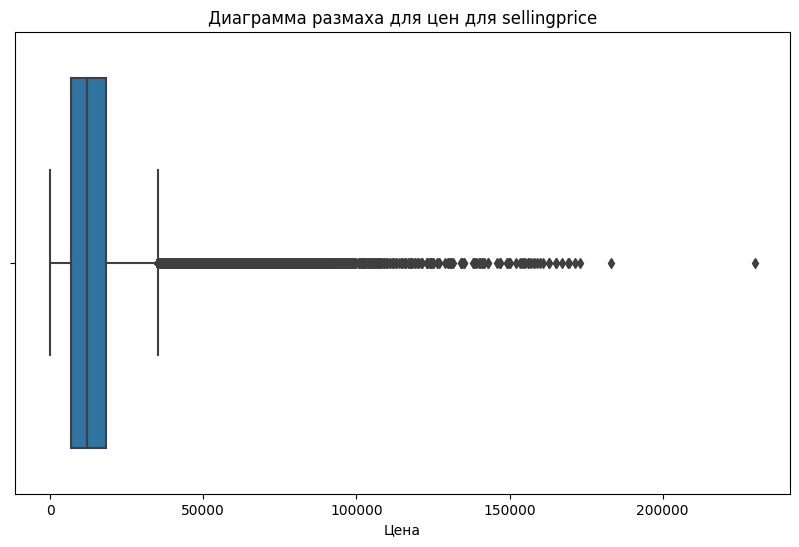

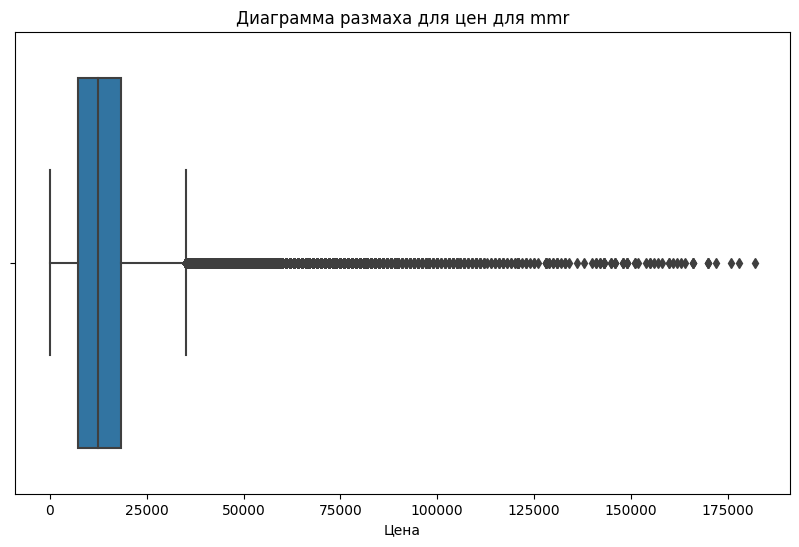

In [20]:
for feature in ['sellingprice', 'mmr']:
    plt.figure(figsize=(10, 6))
    sns.boxplot(x=data[feature])
    plt.title(f'Диаграмма размаха для цен для {feature}')
    plt.xlabel('Цена')
    plt.show()

/usr/local/lib/python3.10/dist-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


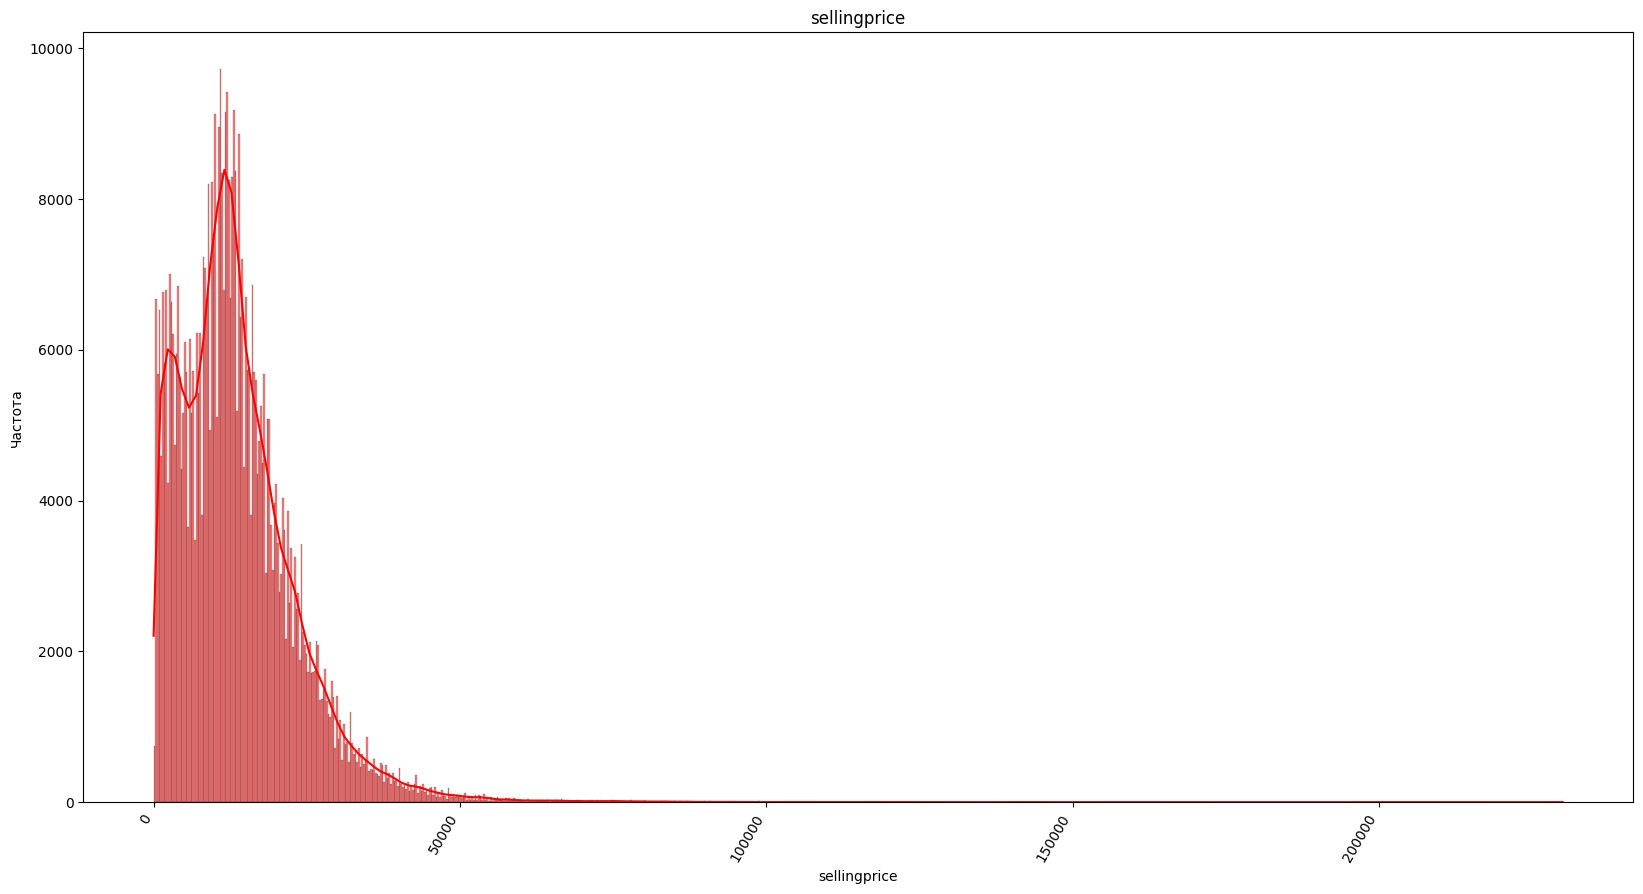

/usr/local/lib/python3.10/dist-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


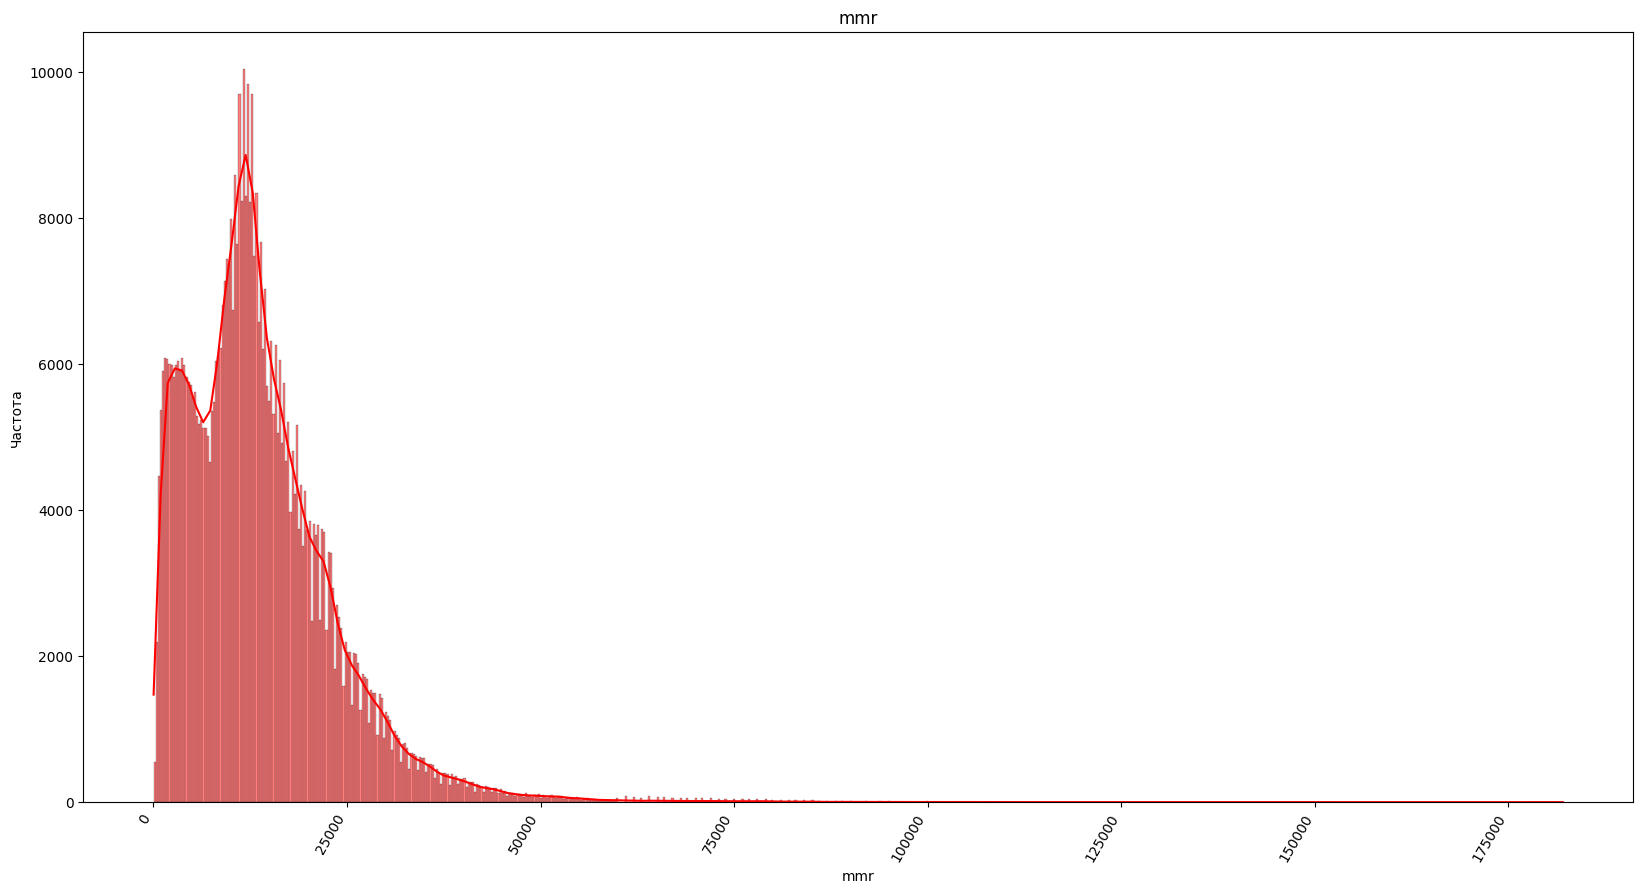

In [21]:
for column in ['sellingprice', 'mmr']:
    plt.figure(figsize=(20, 10))
    sns.histplot(data[column], kde=True, color='red')
    plt.title(f'{column}')
    plt.xlabel(column)
    plt.ylabel('Частота')
    plt.xticks(rotation=60, ha="right");
    plt.show()

На графике видно, что очень много выбросов. Основная часть данных сконцентрирована в диапазоне 0–50,000, но есть значения, уходящие далеко за 100,000 и даже выше 200,000.

Можно конечно удалить данные, тем удлаится не так много (около 1000), но лучше попробовать создать шум

# Шум

Для начала уберём прям совсем карйние случаи и сделаем все категориальные данные строковыми (потому что иначе после добавления шума они стану float) 

In [22]:
data = data[data['mmr'] <= 170_000].copy()
data = data[data['sellingprice'] <= 170_000].copy()
data = data[data['mmr'] >= 100].copy()
data = data[data['sellingprice'] >= 100].copy()
# print('before ', data_0.shape, 'after ', data.shape)

data['year']=data['year'].astype(str)
data['vin_count']=data['vin_count'].astype(str)
data['category']=data['category'].astype(str)
# data['vin_count']=data['vin_count']..astype(str)
print(data.dtypes)

year                  object
make                  object
model                 object
trim                  object
body                  object
transmission          object
vin                   object
state                 object
condition            float64
odometer             float64
color                 object
interior              object
seller                object
mmr                  float64
sellingprice         float64
saledate              object
vin_count             object
country               object
type                  object
safety_system         object
category              object
age                    int64
odometer_per_year    float64
dtype: object


In [23]:
data_train, data_test = train_test_split(data, test_size=0.2, random_state=42)

def add_noise(data, noise_level=0.01):
    noise = np.random.normal(0, noise_level * data, data.shape)  # Пропорциональный шум
    return data + noise

for i in range(4):
    data_train_1 = data_train[data_train['sellingprice'] >= 40_000].copy()
    data_train_2 = data_train[data_train['sellingprice'] >= 80_000].copy()
    # data_train_3 = data_train[data_train['sellingprice'] >= 100_000].copy()
    data_train_4 = data_train[data_train['sellingprice'] >= 120_000].copy()

    for column in data_train_1.select_dtypes(include=['float']):
        data_train_1[column] = add_noise(data_train_1[column])

    for column in data_train_2.select_dtypes(include=['float']):
        data_train_2[column] = add_noise(data_train_2[column])

    # for column in data_train_3.select_dtypes(include=['float']):
    #     data_train_3[column] = add_noise(data_train_3[column])

    for column in data_train_4.select_dtypes(include=['float']):
        data_train_4[column] = add_noise(data_train_4[column])
    
    # data_train = pd.concat([data_train, data_train_1, data_train_2, data_train_3, data_train_4])
    data_train = pd.concat([data_train, data_train_1, data_train_2, data_train_4])
    
    

data_train = data_train.drop_duplicates()  # Убираем полные дубликаты
data_train = data_train[data_train['mmr'] <= 170_000].copy()
data_train = data_train[data_train['sellingprice'] <= 170_000].copy()
data_train

,year,make,model,trim,body,transmission,vin,state,condition,odometer,...,mmr,sellingprice,saledate,vin_count,country,type,safety_system,category,age,odometer_per_year
175482,2008,lexus,rx 350,base,suv,automatic,jtjgk31u480013158,fl,42.000000,103129.000000,...,12950.000000,11500.000000,Wed Jan 28 2015 01:25:00 GMT-0800 (PST),1,japan,gk,ultrasonic sensors,2,17,6066.411765
457022,2012,toyota,camry,se,sedan,automatic,4t1bf1fk2cu164980,ca,38.000000,29279.000000,...,14150.000000,15600.000000,Wed May 27 2015 05:30:00 GMT-0700 (PDT),1,usa,bf,ABS & ESC,2,13,2252.230769
182566,2011,toyota,rav4,base,suv,automatic,2t3bk4dv5bw065117,oh,35.000000,55494.000000,...,14250.000000,16600.000000,Tue Jan 27 2015 01:30:00 GMT-0800 (PST),1,canada,bk,adaptive headlights,3,14,3963.857143
68592,2014,toyota,camry,se,sedan,automatic,4t1bf1fk7eu406181,nv,44.000000,15370.000000,...,16700.000000,16500.000000,Wed Dec 31 2014 12:00:00 GMT-0800 (PST),1,usa,bf,ABS & ESC,3,11,1397.272727
343171,2013,hyundai,sonata,gls,sedan,automatic,5npeb4ac3dh534070,pa,24.000000,32113.000000,...,12750.000000,11800.000000,Fri Feb 27 2015 01:00:00 GMT-0800 (PST),1,usa,eb,full airbags,2,12,2676.083333
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
294643,2013,bentley,continental gt,v8,coupe,automatic,scbft7za2dc082875,pa,48.515741,6624.446303,...,129768.821133,129831.751910,Fri Feb 13 2015 01:00:00 GMT-0800 (PST),1,united kingdom,ft,front airbags,4,12,530.228021
547631,2012,rolls-royce,ghost,ewb,sedan,automatic,sca664l50cux65625,ca,36.498919,11877.416522,...,166231.983526,169433.314341,Thu Jun 18 2015 05:30:00 GMT-0700 (PDT),1,united kingdom,66,advanced airbags,4,13,918.813903
5624,2014,land rover,range rover,autobiography lwb,suv,automatic,salgv3tf1ea155989,ca,44.978789,5410.356950,...,135424.260908,133678.868003,Thu Dec 18 2014 12:30:00 GMT-0800 (PST),1,united kingdom,gv,front & side airbags,4,11,479.753937
362882,2013,bentley,continental gtc,base,convertible,automatic,scbgr3za1dc079560,ca,43.861042,5508.578895,...,156812.114533,161442.784586,Thu Feb 26 2015 04:00:00 GMT-0800 (PST),1,united kingdom,gr,front airbags,4,12,466.983485


/usr/local/lib/python3.10/dist-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


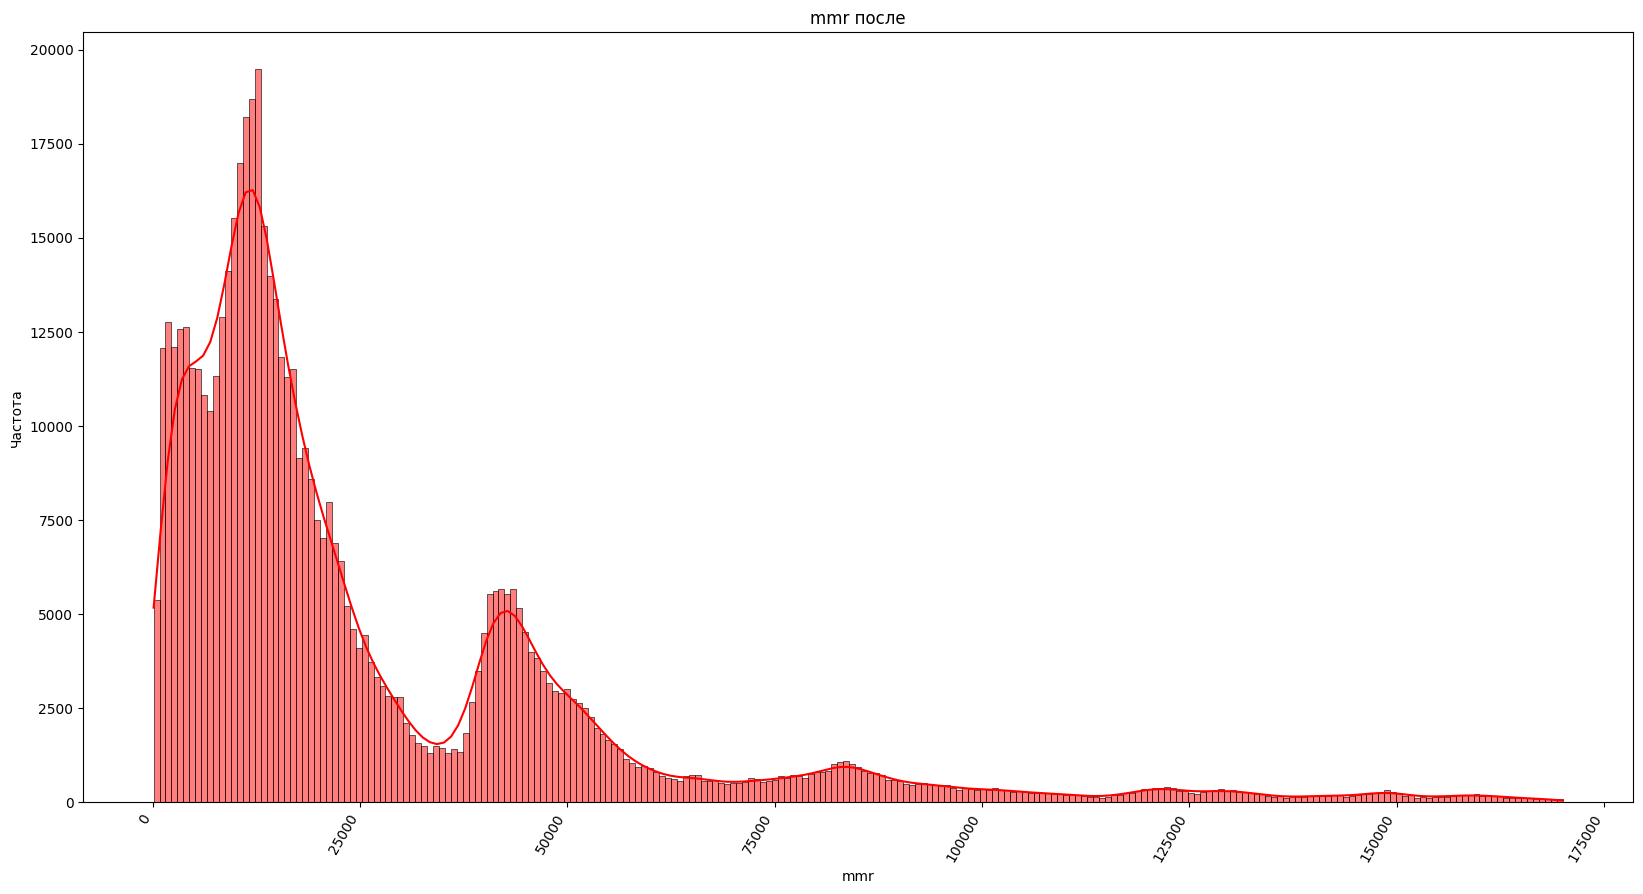

/usr/local/lib/python3.10/dist-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


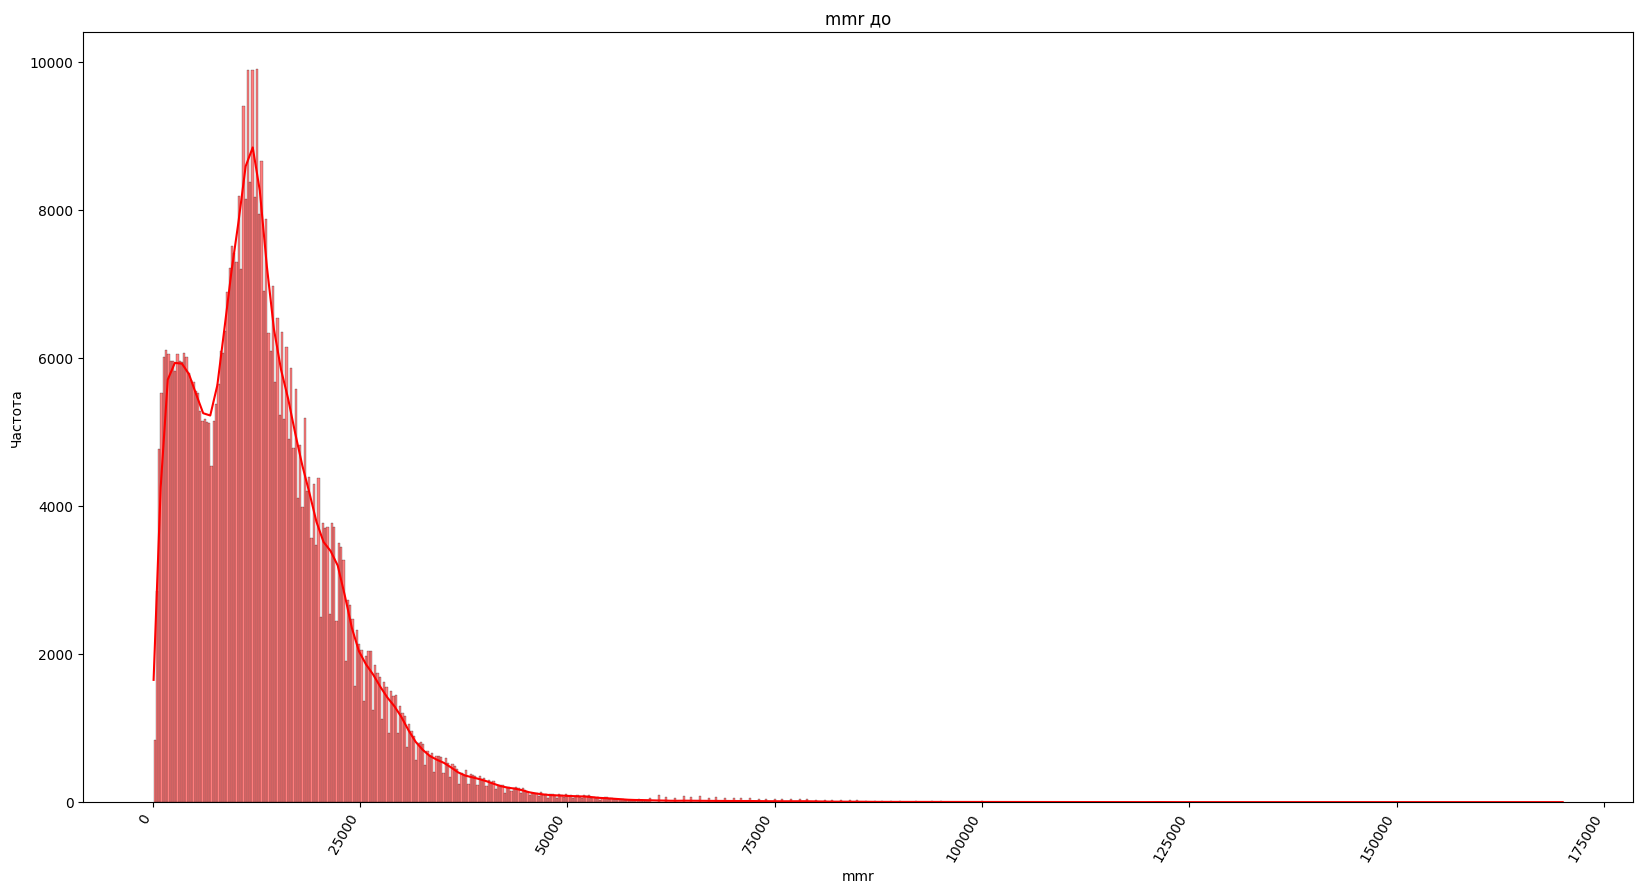

/usr/local/lib/python3.10/dist-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


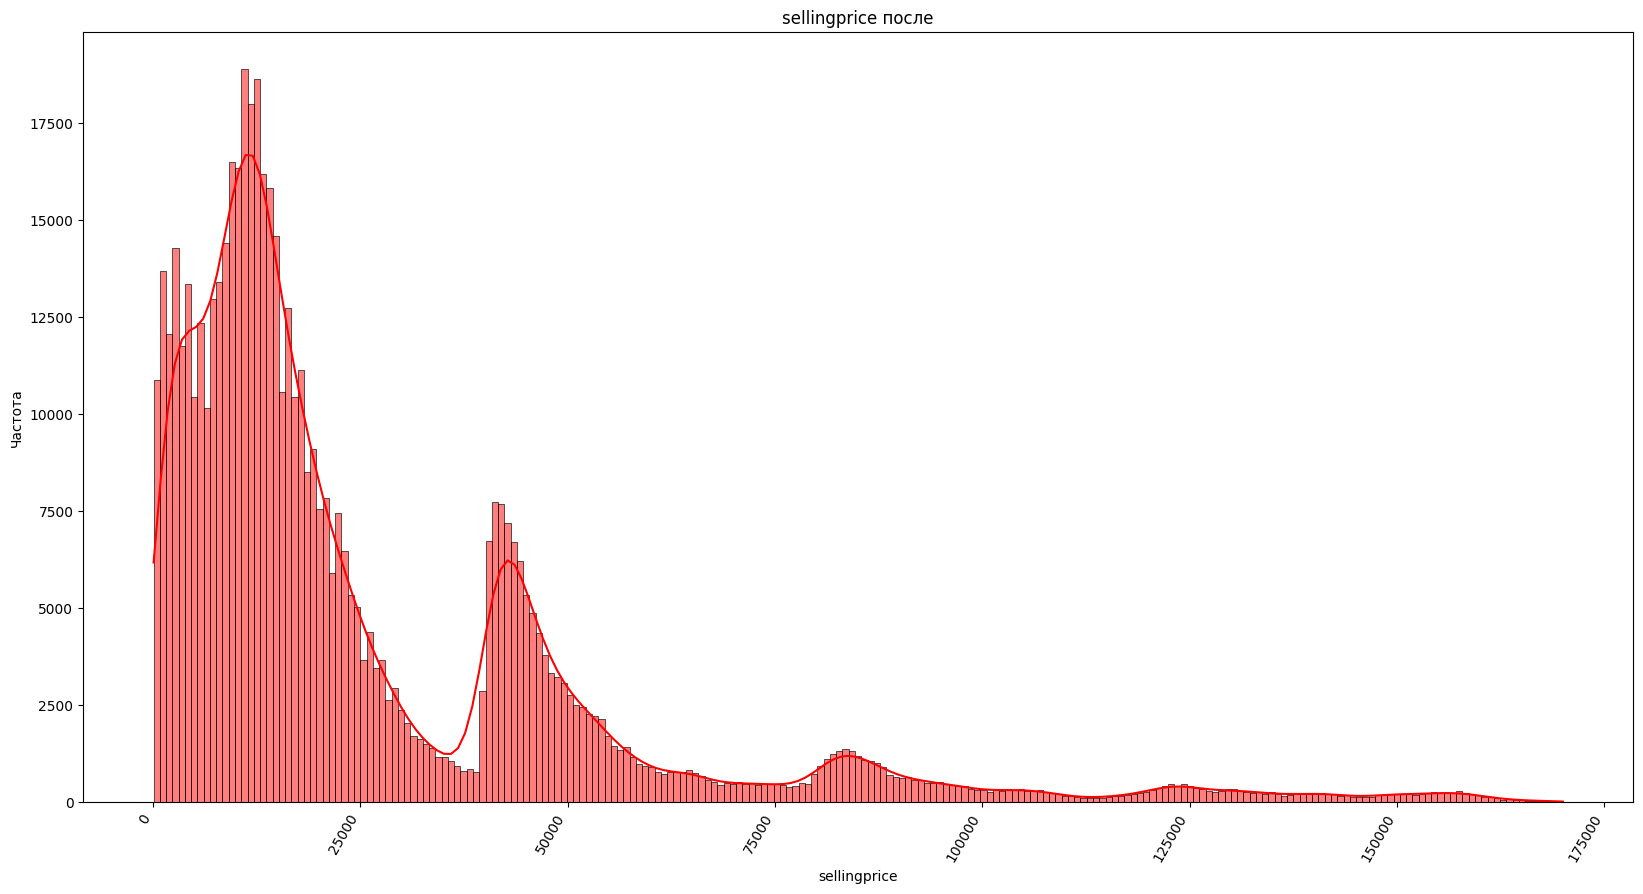

/usr/local/lib/python3.10/dist-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


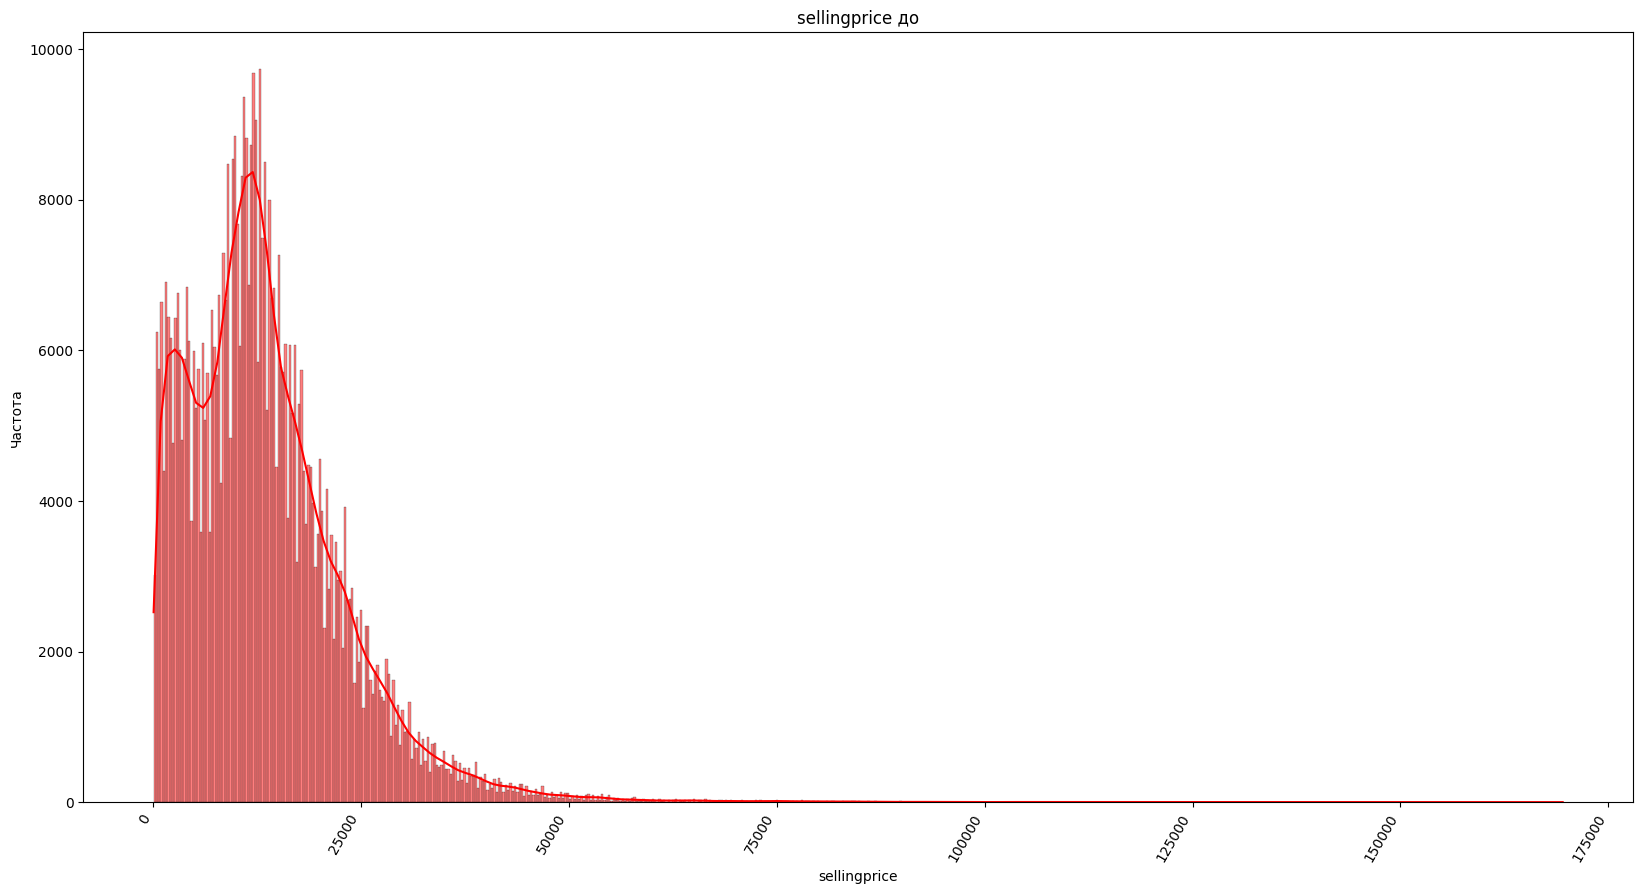

In [24]:
for column in ['mmr', 'sellingprice']:
    plt.figure(figsize=(20, 10))
    sns.histplot(data_train[column], kde=True, color='red')
    plt.title(f'{column} после')
    plt.xlabel(column)
    plt.ylabel('Частота')
    plt.xticks(rotation=60, ha="right");
    plt.show()

    plt.figure(figsize=(20, 10))
    sns.histplot(data[column], kde=True, color='red')
    plt.title(f'{column} до')
    plt.xlabel(column)
    plt.ylabel('Частота')
    plt.xticks(rotation=60, ha="right");
    plt.show()

In [25]:
# 23 столбца
cf = [
    'year',
    'make',
    'model',
    'trim',
    'body',
    'transmission',
   # 'vin',
    'state',
  # 'condition',
   # 'odometer',
    'color' ,
    'interior',    
    'seller',
    # 'mmr',
    # 'sellingprice',
    # 'saledate', 
    'country',
    'category',
    'safety_system',
    # 'age',
    # 'vin_count',
    'type',
    # 'odometer_per_year',
]

In [26]:
for col in cf:
    data_train[col] = data_train[col].astype(str)
    data_test[col] = data_test[col].astype(str)

print(data_train.isnull().sum())
print(data_train.dtypes)

year                 0
make                 0
model                0
trim                 0
body                 0
transmission         0
vin                  0
state                0
condition            0
odometer             0
color                0
interior             0
seller               0
mmr                  0
sellingprice         0
saledate             0
vin_count            0
country              0
type                 0
safety_system        0
category             0
age                  0
odometer_per_year    0
dtype: int64
year                  object
make                  object
model                 object
trim                  object
body                  object
transmission          object
vin                   object
state                 object
condition            float64
odometer             float64
color                 object
interior              object
seller                object
mmr                  float64
sellingprice         float64
saledate              o

# Регрессор №1 (для sellingprice)

In [ ]:
X1 = data_train.drop(columns = ['vin', 'saledate', 'sellingprice'])
y1 = data_train['sellingprice']

X1_train, X1_test, y1_train, y1_test = train_test_split(X1, y1, test_size=0.2, random_state=0)

model1 = CatBoostRegressor(
    iterations=16_000, 
    depth=6, 
    learning_rate=0.05, 
    cat_features=cf, 
    verbose=100, 
    early_stopping_rounds=100,
    eval_metric = 'RMSE',
    loss_function = 'RMSE',
    # l2_leaf_reg = 3,
    # task_type = 'GPU',
)

model1.fit(X1_train, y1_train)

y1_pred = model1.predict(X1_test)

R-squared (R²): 0.9792602675634192
Mean Absolute Error (MAE): 855.923564995753
Mean Squared Error (MSE): 1943612.1044749992
Root Mean Squared Error (RMSE): 1394.1348946479316


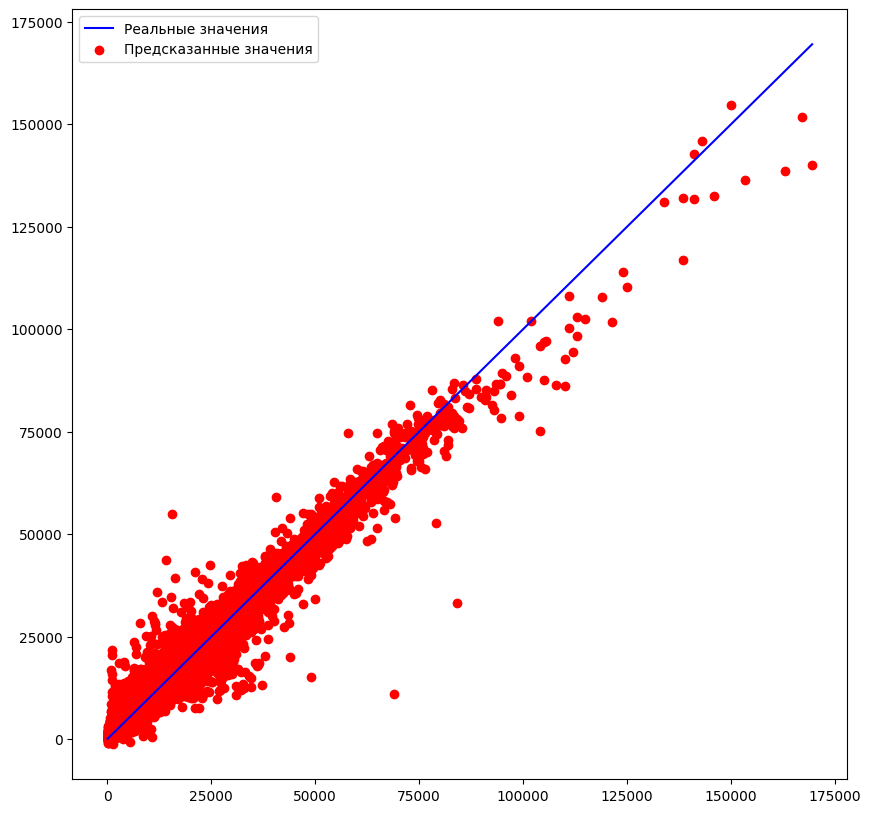

In [33]:
X11 = data_test.drop(columns = ['vin', 'saledate', 'sellingprice'])
y11 = data_test['sellingprice']
y11_pred = model1.predict(X11)


# Ошибки
r2 = r2_score(y11, y11_pred)
print(f'R-squared (R²): {r2}') 

mae = mean_absolute_error(y11, y11_pred)
print(f'Mean Absolute Error (MAE): {mae}') 

mse = mean_squared_error(y11, y11_pred)
print(f'Mean Squared Error (MSE): {mse}')

rmse = np.sqrt(mean_squared_error(y11, y11_pred))
print(f'Root Mean Squared Error (RMSE): {rmse}')


# Визуализация результатов
sample_indices = np.random.choice(len(y11_pred), size=100_000, replace=False)
y_test_sample_11 = np.array(y11)
y_pred_sample_11 = np.array(y11_pred)
    
plt.figure(figsize=(10,10))
#plt.scatter(y_pred_sample, y_pred_sample, color='blue')
plt.plot([min(y_test_sample_11), max(y_test_sample_11)], [min(y_test_sample_11), max(y_test_sample_11)],  color='blue', label='Реальные значения')
plt.scatter(y_test_sample_11, y_pred_sample_11, color='red', label='Предсказанные значения')
plt.legend()
plt.show()

# GPU:
# R-squared (R²): 0.9595862059523121
# Root Mean Squared Error (RMSE): 1946.1129155495696

# R-squared (R²): 0.9792602675634192
# Root Mean Squared Error (RMSE): 1394.1348946479316

Проверим модель на переобучение

In [34]:
'''
train_data = Pool(X1_train, label=y1_train, cat_features=cf)

params = {
    'iterations': 5000,          # Количество итераций
    'depth': 6,                 # Глубина деревьев
    'learning_rate': 0.05,       # Скорость обучения
    'cat_features': cf,          # Индексы категориальных признаков
    'verbose': 100,              # Частота вывода сообщений (каждые 100 итераций)
    'loss_function': 'RMSE',     # Функция потерь для регрессии (среднеквадратическая ошибка)
    'eval_metric': 'RMSE',        # Метрика для оценки качества модели
    'early_stopping_rounds':100
}

# Выполнение кросс-валидации
cv_results = cv(   
    pool=train_data,            # обучающие данные
    params=params,   # параметры модели
    #X1_train, y1_train, 
    fold_count=5,          # количество фолдов
    plot=False,             # для построения графика ошибок
    stratified=False,          # Для регрессии False
    as_pandas=True             # Возвращать результат в виде DataFrame
)

# результаты кросс-валидации
print(cv_results)
'''

"\ntrain_data = Pool(X1_train, label=y1_train, cat_features=cf)\n\nparams = {\n    'iterations': 5000,          # Количество итераций\n    'depth': 6,                 # Глубина деревьев\n    'learning_rate': 0.05,       # Скорость обучения\n    'cat_features': cf,          # Индексы категориальных признаков\n    'verbose': 100,              # Частота вывода сообщений (каждые 100 итераций)\n    'loss_function': 'RMSE',     # Функция потерь для регрессии (среднеквадратическая ошибка)\n    'eval_metric': 'RMSE',        # Метрика для оценки качества модели\n    'early_stopping_rounds':100\n}\n\n# Выполнение кросс-валидации\ncv_results = cv(   \n    pool=train_data,            # обучающие данные\n    params=params,   # параметры модели\n    #X1_train, y1_train, \n    fold_count=5,          # количество фолдов\n    plot=False,             # для построения графика ошибок\n    stratified=False,          # Для регрессии False\n    as_pandas=True             # Возвращать результат в виде DataFra

1. Средняя абсолютная ошибка (MAE — Mean Absolute Error)
2. Среднеквадратическая ошибка (MSE — Mean Squared Error)
3. Корень из среднеквадратической ошибки (RMSE — Root Mean Squared Error
4. Коэффициент детерминации (обозначается как R² или r-squared) — это метрика, которая показывает, насколько хорошо модель предсказывает зависимость между переменными. В контексте регрессионного анализа R² измеряет долю вариации зависимой переменной, которая объясняется независимыми переменными в модели.

# Фичер импортансис

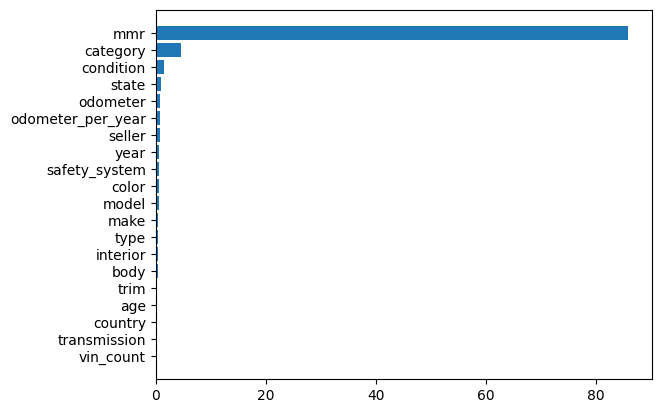

In [35]:
importances = model1.feature_importances_
indices = np.argsort(importances)
fig, ax = plt.subplots()
ax.barh(range(len(importances)), importances[indices])
ax.set_yticks(range(len(importances)))
_ = ax.set_yticklabels(np.array(X1.columns)[indices])

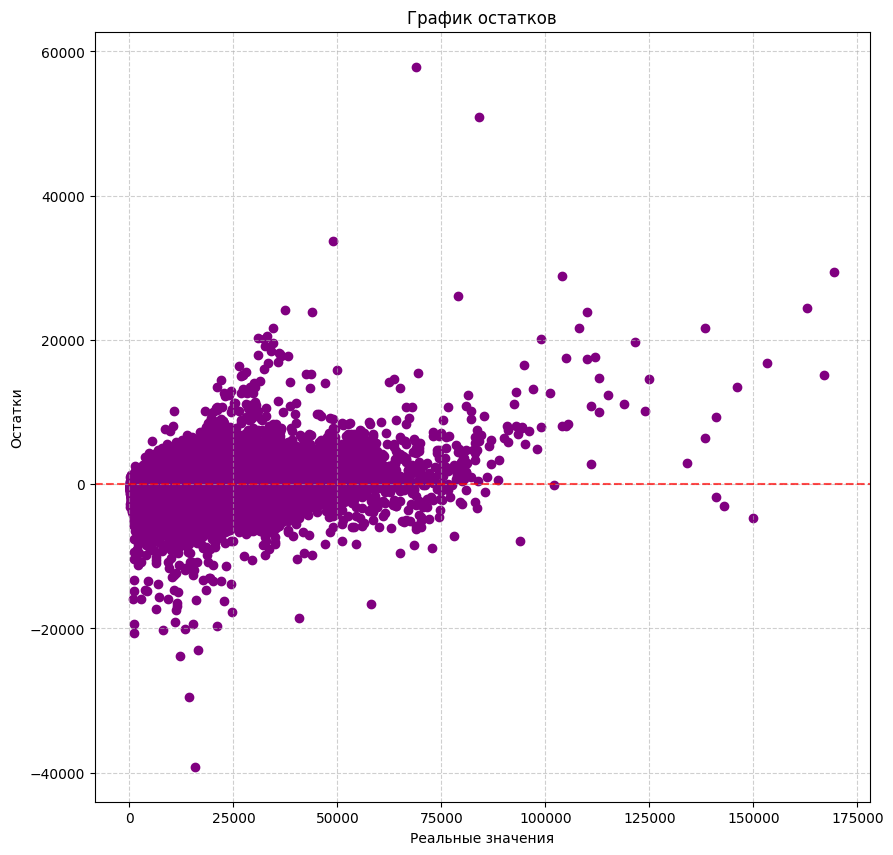

In [36]:
residuals = y_test_sample_11 - y_pred_sample_11
plt.figure(figsize=(10,10))
line = np.linspace(min(y_test_sample_11), max(y_test_sample_11), 1000)
plt.scatter(y_test_sample_11, residuals, color='purple')
plt.axhline(y=0, color='red', linestyle='--', linewidth=1.5, alpha=0.7)  # Линия на уровне 0
plt.title('График остатков')  # Исправлено
plt.xlabel('Реальные значения')
plt.ylabel('Остатки')
plt.grid(True, linestyle='--', alpha=0.6)  # Добавление сетки
plt.show()

# Регрессор №2 (без mmr)

просто удалим самый важный признак и посмотрим, что будет 

In [27]:
X2 = data_train.drop(columns = ['vin', 'saledate', 'sellingprice', 'mmr'])
y2 = data_train['sellingprice']

X2_train, X2_test, y2_train, y2_test = train_test_split(X2, y2, test_size=0.2, random_state=0)

model2 = CatBoostRegressor(
    iterations=15_000, 
    depth=6, 
    learning_rate=0.05, 
    cat_features=cf, 
    verbose=100, 
    early_stopping_rounds=100,
    random_state = 42,
    eval_metric = 'RMSE',
    loss_function = 'RMSE',
    l2_leaf_reg = 3,
    # task_type = 'GPU',
)

model2.fit(X2_train, y2_train)

y2_pred = model2.predict(X2_test)

0:	learn: 27351.2160792	total: 721ms	remaining: 3h 20s
100:	learn: 6513.8351807	total: 56.9s	remaining: 2h 19m 56s
200:	learn: 5142.2684114	total: 1m 54s	remaining: 2h 20m 46s
300:	learn: 4485.1976833	total: 2m 51s	remaining: 2h 19m 40s
400:	learn: 4069.0417126	total: 3m 49s	remaining: 2h 19m 22s
500:	learn: 3772.3922819	total: 4m 47s	remaining: 2h 18m 28s
600:	learn: 3539.7490179	total: 5m 45s	remaining: 2h 17m 47s
700:	learn: 3361.8307654	total: 6m 43s	remaining: 2h 17m 9s
800:	learn: 3227.9989746	total: 7m 41s	remaining: 2h 16m 16s
900:	learn: 3109.5224829	total: 8m 38s	remaining: 2h 15m 19s
1000:	learn: 3015.2729516	total: 9m 38s	remaining: 2h 14m 55s
1100:	learn: 2931.0829330	total: 10m 36s	remaining: 2h 13m 57s
1200:	learn: 2862.2203236	total: 11m 35s	remaining: 2h 13m 12s
1300:	learn: 2800.3312367	total: 12m 31s	remaining: 2h 11m 56s
1400:	learn: 2741.2380238	total: 13m 29s	remaining: 2h 11m
1500:	learn: 2688.0093112	total: 14m 27s	remaining: 2h 9m 59s
1600:	learn: 2639.5403289	

Root Mean Squared Error (RMSE): 1716.328742815611
0.9685663722894974


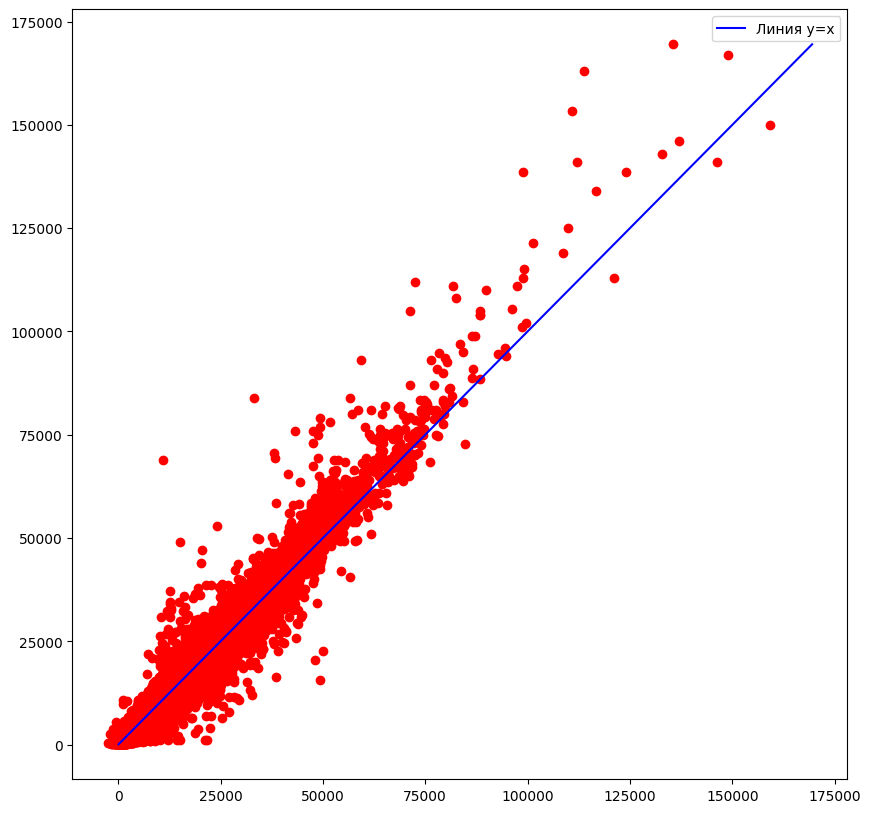

In [48]:
X21 = data_test.drop(columns = ['vin', 'saledate', 'sellingprice', 'mmr'])
y21_test = data_test['sellingprice']
y21_pred = model2.predict(X21)

# error и score
rmse = np.sqrt(mean_squared_error(y21_test, y21_pred))
print(f'Root Mean Squared Error (RMSE): {rmse}')
print(r2_score(y21_test, y21_pred))

# визуализация
sample_indices = np.random.choice(len(y21_pred), size=100_000, replace=False)
y_test_sample_21 = np.array(y21_test)[sample_indices]
y_pred_sample_21 = np.array(y21_pred)[sample_indices]

plt.figure(figsize=(10,10))
plt.plot([y_test_sample_21.min(), y_test_sample_21.max()], 
         [y_test_sample_21.min(), y_test_sample_21.max()], 
         color='blue', linestyle='-', label='Линия y=x')
plt.scatter(y_pred_sample_21, y_test_sample_21, color='red')
plt.legend()
plt.show()

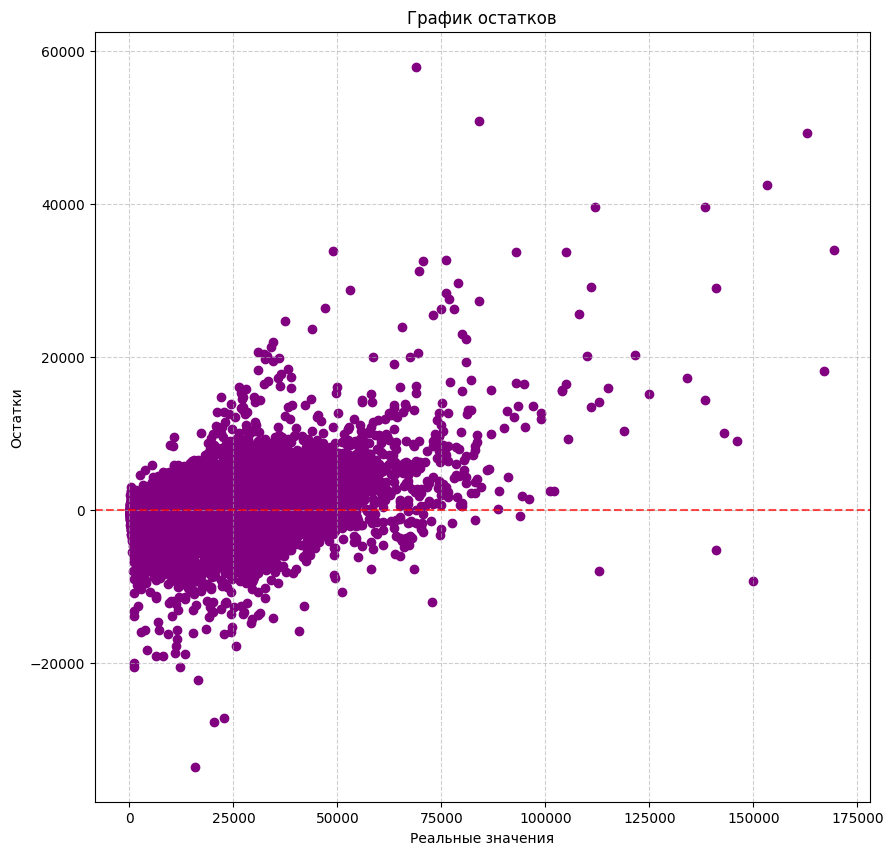

In [49]:
residuals = y_test_sample_21 - y_pred_sample_21
plt.figure(figsize=(10,10))
line = np.linspace(min(y_test_sample_21), max(y_test_sample_21), 1000)
plt.scatter(y_test_sample_21, residuals, color='purple')
plt.axhline(y=0, color='red', linestyle='--', linewidth=1.5, alpha=0.7)  # Линия на уровне 0
plt.title('График остатков')  # Исправлено
plt.xlabel('Реальные значения')
plt.ylabel('Остатки')
plt.grid(True, linestyle='--', alpha=0.6)  # Добавление сетки
plt.show()

# Отношениие mmr и sellingpice

In [30]:
data_diff = data.copy()

data_diff['diff'] = abs(data['mmr'] - data['sellingprice'])
data_diff['sign'] = data['mmr'] > data['sellingprice'] #True - машина стала дешевле, Fasle - машина стала дороже/не изменилась

data_diff

,year,make,model,trim,body,transmission,vin,state,condition,odometer,...,saledate,vin_count,country,type,safety_system,category,age,odometer_per_year,diff,sign
0,2015,kia,sorento,lx,suv,automatic,5xyktca69fg566472,ca,5.0,16639.0,...,Tue Dec 16 2014 12:30:00 GMT-0800 (PST),1,usa,kt,ABS,4,10,1663.900000,1000.0,False
1,2015,kia,sorento,lx,suv,automatic,5xyktca69fg561319,ca,5.0,9393.0,...,Tue Dec 16 2014 12:30:00 GMT-0800 (PST),1,usa,kt,ABS,4,10,939.300000,700.0,False
2,2014,bmw,3 series,328i sulev,sedan,automatic,wba3c1c51ek116351,ca,45.0,1331.0,...,Thu Jan 15 2015 04:30:00 GMT-0800 (PST),1,germany,3c,advanced airbags,4,11,121.000000,1900.0,True
3,2015,volvo,s60,t5,sedan,automatic,yv1612tb4f1310987,ca,41.0,14282.0,...,Thu Jan 29 2015 04:30:00 GMT-0800 (PST),1,sweden,61,front & side airbags,4,10,1428.200000,250.0,False
4,2014,bmw,6 series gran coupe,650i,sedan,automatic,wba6b2c57ed129731,ca,43.0,2641.0,...,Thu Dec 18 2014 12:30:00 GMT-0800 (PST),1,germany,6b,advanced airbags,4,11,240.090909,1000.0,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
548838,2015,kia,k900,luxury,sedan,automatic,knalw4d4xf6019304,in,45.0,18255.0,...,Thu Jul 09 2015 07:00:00 GMT-0700 (PDT),1,south korea,lw,full airbags,4,10,1825.500000,2300.0,True
548839,2012,ram,2500,power wagon,crew cab,automatic,3c6td5et6cg112407,wa,5.0,54393.0,...,Wed Jul 08 2015 09:30:00 GMT-0700 (PDT),1,mexico,td,TPMS,4,13,4184.076923,600.0,False
548840,2012,bmw,x5,xdrive35d,suv,automatic,5uxzw0c58cl668465,ca,48.0,50561.0,...,Wed Jul 08 2015 09:30:00 GMT-0700 (PDT),1,usa,zw,advanced airbags,4,13,3889.307692,4200.0,False
548841,2015,nissan,altima,2.5 s,sedan,automatic,1n4al3ap0fc216050,ga,38.0,16658.0,...,Thu Jul 09 2015 06:45:00 GMT-0700 (PDT),1,usa,al,parking sensors,3,10,1665.800000,4000.0,True


# Регрессор №3 и логистическая (изменение цен)

Предсказание того, на сколько изменится цена, и увеличится она или уменьшится

In [31]:
X3 = data_diff.drop(columns = ['vin', 'saledate', 'mmr', 'sellingprice', 'diff', 'sign'])
y3 = data_diff['diff']
y_sign = data_diff['sign']

X3_train, X3_test, y3_train, y3_test = train_test_split(X3, y3, test_size=0.2, random_state=0)
X_sign_train, X_sign_test, y_sign_train, y_sign_test = train_test_split(X3, y_sign, test_size=0.2, random_state=0)

0:	learn: 1342.7025234	total: 516ms	remaining: 1h 26m 3s
100:	learn: 1162.7835691	total: 52.5s	remaining: 1h 25m 42s
200:	learn: 1141.3966717	total: 1m 45s	remaining: 1h 25m 43s
300:	learn: 1131.5966287	total: 2m 37s	remaining: 1h 24m 26s
400:	learn: 1124.8511332	total: 3m 31s	remaining: 1h 24m 27s
500:	learn: 1119.6838112	total: 4m 27s	remaining: 1h 24m 23s
600:	learn: 1116.0811457	total: 5m 21s	remaining: 1h 23m 45s
700:	learn: 1112.9110847	total: 6m 15s	remaining: 1h 23m 4s
800:	learn: 1110.0040905	total: 7m 11s	remaining: 1h 22m 33s
900:	learn: 1107.2933396	total: 8m 5s	remaining: 1h 21m 39s
1000:	learn: 1104.6579524	total: 9m	remaining: 1h 20m 57s
1100:	learn: 1102.2962071	total: 9m 55s	remaining: 1h 20m 15s
1200:	learn: 1099.6368350	total: 10m 51s	remaining: 1h 19m 30s
1300:	learn: 1097.6710717	total: 11m 45s	remaining: 1h 18m 34s
1400:	learn: 1095.6993967	total: 12m 40s	remaining: 1h 17m 45s
1500:	learn: 1093.6484776	total: 13m 36s	remaining: 1h 17m 1s
1600:	learn: 1091.8229366	

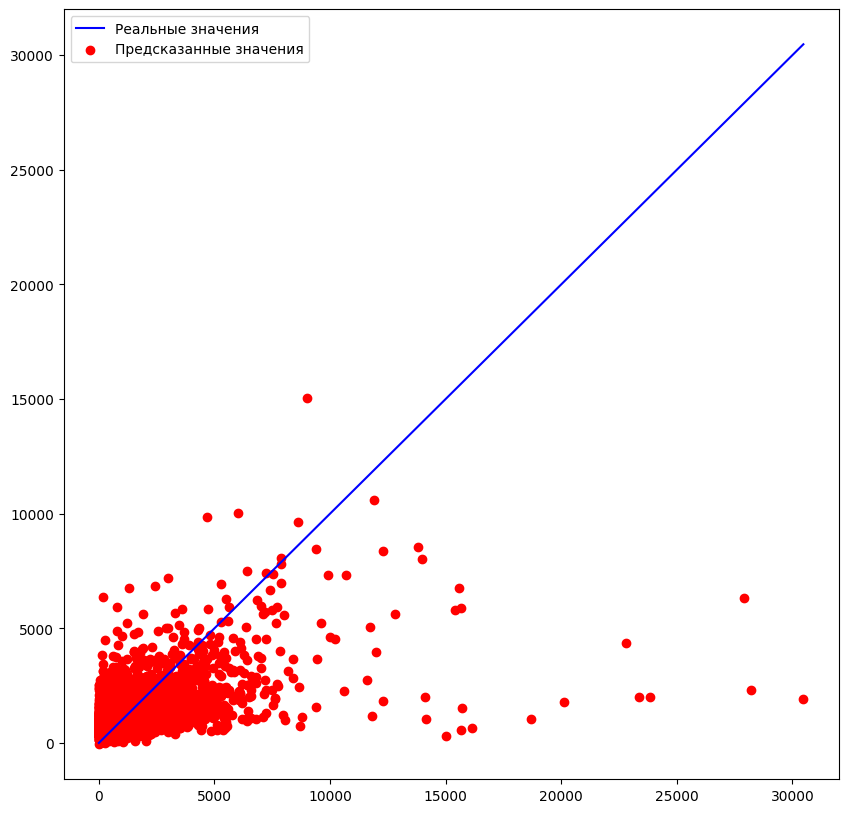

In [55]:
model3 = CatBoostRegressor(
    iterations=10_000, 
    depth=6, 
    learning_rate=0.05, 
    cat_features=cf, 
    verbose=100, 
    early_stopping_rounds=50
)

model3.fit(X3_train, y3_train)
y3_pred = model3.predict(X3_test)

print('RMSE: ', np.sqrt(mean_squared_error(y3_test, y3_pred)))
print('r2_score: ', r2_score(y3_test, y3_pred))


# визуализация
sample_indices = np.random.choice(len(y3_pred), size=10000, replace=False)
y_test_sample = np.array(y3_test)[sample_indices]
y_pred_sample = np.array(y3_pred)[sample_indices]

plt.figure(figsize=(10,10))
#plt.scatter(y_pred_sample, y_pred_sample, color='blue')
plt.plot([min(y_test_sample), max(y_test_sample)], [min(y_test_sample), max(y_test_sample)],  color='blue', label='Реальные значения')
plt.scatter(y_test_sample, y_pred_sample, color='red', label='Предсказанные значения')
plt.legend()
plt.show()

0:	learn: 0.6867989	total: 747ms	remaining: 2h 4m 30s
100:	learn: 0.5784888	total: 1m 2s	remaining: 1h 42m 21s
200:	learn: 0.5681612	total: 2m 4s	remaining: 1h 40m 59s
300:	learn: 0.5624882	total: 3m 8s	remaining: 1h 41m 17s
400:	learn: 0.5587089	total: 4m 12s	remaining: 1h 40m 50s
500:	learn: 0.5559840	total: 5m 17s	remaining: 1h 40m 16s
600:	learn: 0.5539729	total: 6m 20s	remaining: 1h 39m 12s
700:	learn: 0.5522428	total: 7m 25s	remaining: 1h 38m 24s
800:	learn: 0.5507458	total: 8m 29s	remaining: 1h 37m 30s
900:	learn: 0.5493225	total: 9m 34s	remaining: 1h 36m 40s
1000:	learn: 0.5483237	total: 10m 38s	remaining: 1h 35m 40s
1100:	learn: 0.5472592	total: 11m 43s	remaining: 1h 34m 42s
1200:	learn: 0.5462854	total: 12m 46s	remaining: 1h 33m 38s
1300:	learn: 0.5453836	total: 13m 51s	remaining: 1h 32m 39s
1400:	learn: 0.5444871	total: 14m 56s	remaining: 1h 31m 41s
1500:	learn: 0.5436394	total: 16m 1s	remaining: 1h 30m 41s
1600:	learn: 0.5429071	total: 17m 4s	remaining: 1h 29m 35s
1700:	lea

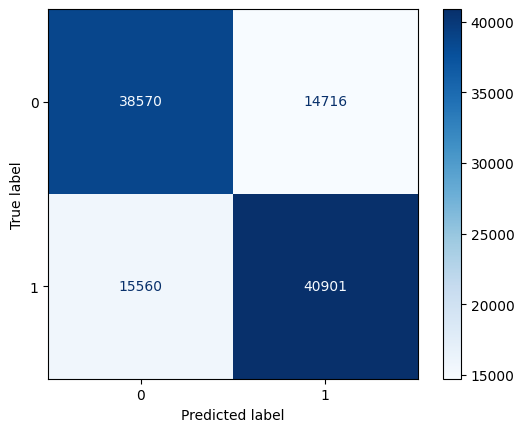

In [32]:
model_sign = CatBoostClassifier(
    iterations=10_000, 
    depth=6, 
    learning_rate=0.05, 
    cat_features=cf, 
    verbose=100, 
    early_stopping_rounds=50    
)

model_sign.fit(X_sign_train, y_sign_train)
y_sign_pred = model_sign.predict(X_sign_test)

print(classification_report(y_sign_test, y_sign_pred))

# матрица ошибок
cm = confusion_matrix(y_sign_test, y_sign_pred) 
disp = ConfusionMatrixDisplay(confusion_matrix=cm)
disp.plot(cmap='Blues') 
plt.show()

Получается, что изменения цен предсказываются плохо. Наверное, стоило оставить mmr. А ещё лучше sale date посмотреть